## Modelo ML

##### Librerias y limpieza

In [2]:
#Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

url= 'https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv'
df = pd.read_csv(url, sep=';', encoding='utf-8', quotechar='"')
target ='y'

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10968
           1       0.68      0.42      0.52      1389

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357

ROC-AUC: 0.9364067942398305


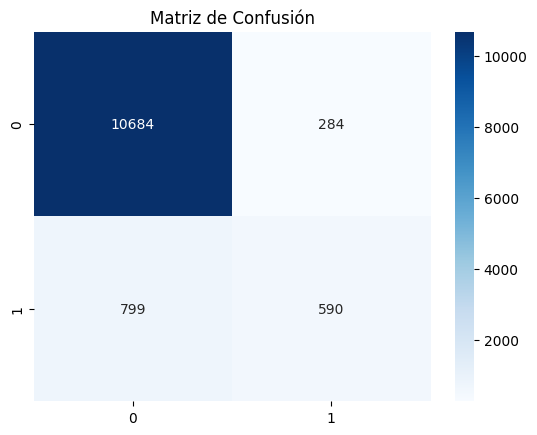

In [ ]:
#Train / test
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == 'yes' else 0)

num_features = X.select_dtypes(include=['int64','float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('logreg', LogisticRegression(max_iter=1000))
])
# Divido el en train y test al 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

# ENTRENAR MODELO
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.show() 


Por lo que veo es que el modelo es muy bueno, tiene un indice de precision del 93% y un accuaracy del 91%

In [ ]:
#optimizacion del modelo
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs']
}

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor AUC:", grid.best_score_)